Load libraries

In [1]:
from data_loader import load_cifar10
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
import joblib
import json
from skimage.feature import hog
from skimage import color, exposure

In [2]:
data = load_cifar10("cifar-10-batches-py")
X_train, y_train = data["x_train"], data["y_train"]
X_test, y_test   = data["x_test"], data["y_test"]
label_names = data["label_names"]

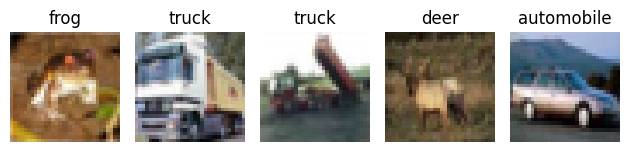

In [5]:
for i in range(5):
    img = X_train[i]
    label_idx = y_train[i]
    label_name = label_names[label_idx]

    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

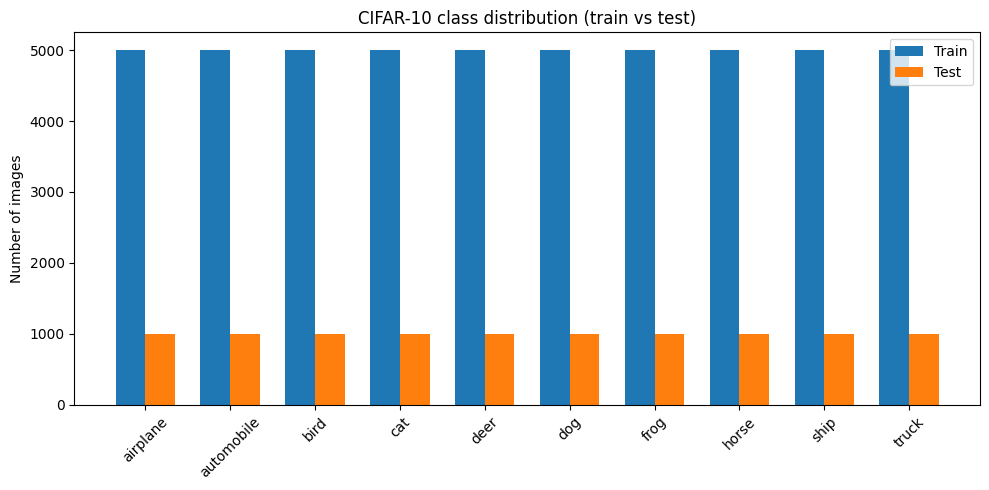

In [3]:
# Count instances per class for train and test
train_counts = np.bincount(y_train, minlength=len(label_names))
test_counts  = np.bincount(y_test,  minlength=len(label_names))

x = np.arange(len(label_names))  # class indices
width = 0.35                     # bar width

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train_counts, width, label="Train")
plt.bar(x + width/2, test_counts,  width, label="Test")

plt.xticks(x, label_names, rotation=45)
plt.ylabel("Number of images")
plt.title("CIFAR-10 class distribution (train vs test)")
plt.legend()
plt.tight_layout()
plt.show()


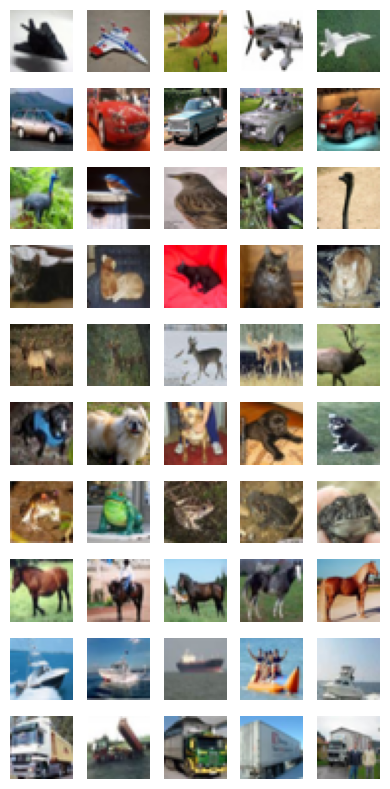

In [7]:
num_classes = len(label_names)
num_examples_per_class = 5

plt.figure(figsize=(num_examples_per_class -1, num_classes -2))

for class_idx in range(num_classes):
    # indices of images belonging to this class
    idxs = np.where(y_train == class_idx)[0]
    # pick first N (or random if you prefer)
    chosen_idxs = idxs[:num_examples_per_class]

    for j, img_idx in enumerate(chosen_idxs):
        plt_idx = class_idx * num_examples_per_class + j + 1
        ax = plt.subplot(num_classes, num_examples_per_class, plt_idx)
        ax.imshow(X_train[img_idx])
        if j == 0:
            ax.set_ylabel(label_names[class_idx], rotation=0, labelpad=40,
                          va="center", ha="right", fontsize=10)
        ax.axis("off")

plt.tight_layout()
plt.show()


Flatten + scale images <br>
CIFAR-10: (N, 32, 32, 3) -> (N, 3072)

In [4]:
X_train_flat = X_train.reshape(len(X_train), -1) / 255.0
X_test_flat  = X_test.reshape(len(X_test), -1) / 255.0

In [4]:
X_train.shape

(50000, 32, 32, 3)

In [10]:
X_train_flat.shape

(50000, 3072)

In [5]:

# Υποθετουμε οτι:
# X_train_flat, X_test_flat ειναι ηδη φλαταρισμενα και scaled
# y_train, y_test ειναι np.arrays με labels 0..9
# label_names = ["airplane", "automobile", ..., "truck"]
def select_stratified_subset(
    X_train_flat, y_train,
    X_test_flat, y_test,
    n_train_per_class, n_test_per_class,
    random_state=0):
    
    num_classes = len(label_names)

    rng = np.random.default_rng(random_state)  # για αναπαραγωγιμοτητα

    # ----------------------------
    # Stratified sampling για TRAIN
    # ----------------------------
    train_indices = []

    for c in range(num_classes):
        class_idxs = np.where(y_train == c)[0]
        # ασφαλεια: να μην ζητησουμε περισσοτερα απο οσα υπαρχουν
        if len(class_idxs) < n_train_per_class:
            raise ValueError(
                f"Not enough train samples for class {c}: "
                f"have {len(class_idxs)}, requested {n_train_per_class}"
            )
        chosen = rng.choice(class_idxs, size=n_train_per_class, replace=False)
        train_indices.append(chosen)

    train_indices = np.concatenate(train_indices)
    rng.shuffle(train_indices)  # ανακατεμα για να μην ειναι ολα της ιδιας κλασης μαζι

    X_train_sub = X_train_flat[train_indices]
    y_train_sub = y_train[train_indices]

    # ----------------------------
    # Stratified sampling για TEST
    # ----------------------------
    test_indices = []

    for c in range(num_classes):
        class_idxs = np.where(y_test == c)[0]
        if len(class_idxs) < n_test_per_class:
            raise ValueError(
                f"Not enough test samples for class {c}: "
                f"have {len(class_idxs)}, requested {n_test_per_class}"
            )
        chosen = rng.choice(class_idxs, size=n_test_per_class, replace=False)
        test_indices.append(chosen)

    test_indices = np.concatenate(test_indices)
    rng.shuffle(test_indices)

    X_test_sub = X_test_flat[test_indices]
    y_test_sub = y_test[test_indices]

    print("Train shape:", X_train_sub.shape, "Test shape:", X_test_sub.shape)
    return X_train_sub, y_train_sub, X_test_sub, y_test_sub


Define SVM configurations <br>
Mix of linear / non-linear kernels and params

In [6]:
model_configs = [
    {
        "name": "LinearSVC_C1",
        "cls": LinearSVC,
        "params": {"C": 1.0, "max_iter": 5000},
    },
    {
        "name": "SVC_poly_deg3_C1",
        "cls": SVC,
        "params": {"kernel": "poly", "degree": 3, "C": 1.0, "gamma": "scale"},
    },
    {
        "name": "SVC_linear_C1",
        "cls": SVC,
        "params": {"kernel": "linear", "C": 1.0},
    },
    {
        "name": "SVC_rbf_C1_gamma1e-3",
        "cls": SVC,
        "params": {"kernel": "rbf", "C": 1.0, "gamma": 1e-3},
    },
    {
        "name": "SVC_rbf_C10_gamma1e-3",
        "cls": SVC,
        "params": {"kernel": "rbf", "C": 10.0, "gamma": 1e-3},
    },
    {
        "name": "SVC_rbf_C100_gamma1e-3",
        "cls": SVC,
        "params": {"kernel": "rbf", "C": 100.0, "gamma": 1e-3},
    }
]

Train all models, time them, compute metrics

In [13]:

results = []  # list of dicts, one per model
X_train_sub, y_train_sub, X_test_sub, y_test_sub = select_stratified_subset(
                                                                    X_train_flat, y_train,
                                                                    X_test_flat, y_test,
                                                                    n_train_per_class=1000,
                                                                    n_test_per_class=200)
os.makedirs("saved_models", exist_ok=True)
for cfg in model_configs:
    print(f"\nTraining {cfg['name']}...")
    model = cfg["cls"](**cfg["params"])

    start = time.perf_counter()
    model.fit(X_train_sub, y_train_sub)
    train_time = time.perf_counter() - start

    y_pred = model.predict(X_test_sub)
    acc = accuracy_score(y_test_sub, y_pred)
    macro_f1 = f1_score(y_test_sub, y_pred, average="macro")

    results.append({
        "name": cfg["name"],
        "model": model,              # trained model object
        "train_time": train_time,
        "test_accuracy": acc,
        "test_macro_f1": macro_f1,
    })
    # --- save model to disk ---
    model_path = os.path.join("saved_models", f"{cfg['name']}.joblib")
    joblib.dump(model, model_path)
    # --------------------------
    print(f"Done in {train_time:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    print(results[-1])

Train shape: (10000, 3072) Test shape: (2000, 3072)

Training LinearSVC_C1...
Done in 27.46 sec - Test Acc: 0.3385, Macro F1: 0.3191
{'name': 'LinearSVC_C1', 'model': LinearSVC(max_iter=5000), 'train_time': 27.458891408052295, 'test_accuracy': 0.3385, 'test_macro_f1': 0.3191178319042876}

Training SVC_poly_deg3_C1...
Done in 215.21 sec - Test Acc: 0.4400, Macro F1: 0.4412
{'name': 'SVC_poly_deg3_C1', 'model': SVC(kernel='poly'), 'train_time': 215.21205796394497, 'test_accuracy': 0.44, 'test_macro_f1': 0.4412348287022736}

Training SVC_linear_C1...
Done in 361.96 sec - Test Acc: 0.2540, Macro F1: 0.2167
{'name': 'SVC_linear_C1', 'model': SVC(kernel='linear'), 'train_time': 361.95542171713896, 'test_accuracy': 0.254, 'test_macro_f1': 0.21673848619049566}

Training SVC_rbf_C1_gamma1e-3...
Done in 379.49 sec - Test Acc: 0.2430, Macro F1: 0.1965
{'name': 'SVC_rbf_C1_gamma1e-3', 'model': SVC(gamma=0.001), 'train_time': 379.487644164823, 'test_accuracy': 0.243, 'test_macro_f1': 0.196517484077

In [14]:
summary = [
    {
        "name": r["name"],
        "train_time": r["train_time"],
        "test_accuracy": r["test_accuracy"],
        "test_macro_f1": r["test_macro_f1"],
    }
    for r in results
]

with open("saved_models/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)

In [7]:
# If I want to load models
X_train_sub, y_train_sub, X_test_sub, y_test_sub = select_stratified_subset(
                                                                    X_train_flat, y_train,
                                                                    X_test_flat, y_test,
                                                                    n_train_per_class=1000,
                                                                    n_test_per_class=200)
model = joblib.load("saved_models/SVC_poly_deg3_C1.joblib")
y_pred = model.predict(X_test_sub)  # or on new data
results = json.load(open("saved_models/metrics.json"))

Train shape: (10000, 3072) Test shape: (2000, 3072)


Train with whole dataset

In [ ]:
results_whole = []  # list of dicts, one per model

for cfg in model_configs:
    print(f"\nTraining {cfg['name']}...")
    model = cfg["cls"](**cfg["params"])

    start = time.perf_counter()
    model.fit(X_train_flat, y_train)
    train_time = time.perf_counter() - start

    y_pred = model.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    results_whole.append({
        "name": cfg["name"],
        "model": model,              # trained model object
        "train_time": train_time,
        "test_accuracy": acc,
        "test_macro_f1": macro_f1,
    })
    print(f"Done in {train_time:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    print(results_whole[-1])


Training LinearSVC_C1...
Done in 185.21 sec - Test Acc: 0.3854, Macro F1: 0.3707
{'name': 'LinearSVC_C1', 'model': LinearSVC(max_iter=5000), 'train_time': 185.2064324740786, 'test_accuracy': 0.3854, 'test_macro_f1': 0.37072591855909}

Training SVC_poly_deg3_C1...
Done in 5485.68 sec - Test Acc: 0.5244, Macro F1: 0.5254
{'name': 'SVC_poly_deg3_C1', 'model': SVC(kernel='poly'), 'train_time': 5485.675329788122, 'test_accuracy': 0.5244, 'test_macro_f1': 0.5253653619836991}

Training SVC_linear_C1...


In [8]:
results[1]

{'name': 'SVC_poly_deg3_C1',
 'train_time': 215.21205796394497,
 'test_accuracy': 0.44,
 'test_macro_f1': 0.4412348287022736}

Random guessing on 10 classes → 10% accuracy. ~44% (poly degree 3) means models *are* learning something.

In [16]:

# start from raw floats (no /255 yet, we let the scaler handle it)
X_train_flat2 = X_train.reshape(len(X_train), -1).astype("float32")
X_test_flat2  = X_test.reshape(len(X_test), -1).astype("float32")

In [18]:
X_train_sub2, y_train_sub2, X_test_sub2, y_test_sub2 = select_stratified_subset(
                                                                    X_train_flat2, y_train,
                                                                    X_test_flat2, y_test,
                                                                    n_train_per_class=1000,
                                                                    n_test_per_class=200)

Train shape: (10000, 3072) Test shape: (2000, 3072)


In [ ]:
linear_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", results[1]["model"])
])

start = time.perf_counter()
linear_pipe.fit(X_train_sub2, y_train_sub2)
t = time.perf_counter() - start

y_pred = linear_pipe.predict(X_test_sub2)
acc = accuracy_score(y_test_sub2, y_pred)
macro_f1 = f1_score(y_test_sub2, y_pred, average="macro")

print(f"SVC_poly_deg3_C1 + scaling: time={t:.2f}s, acc={acc:.4f}, macro F1={macro_f1:.4f}")


LinearSVC + scaling: time=286.65s, acc=0.3845, macro F1=0.3959


In [20]:
results.append({
    "name": "SVC_poly_deg3_C1_with_scaling",
    "train_time": t,
    "model": linear_pipe,
    "test_accuracy": acc,
    "test_macro_f1": macro_f1,
})

In [22]:
model_path = os.path.join("saved_models", f"SVC_poly_deg3_C1_with_scaling.joblib")
joblib.dump(model, model_path)
summary = [
    {
        "name": r["name"],
        "train_time": r["train_time"],
        "test_accuracy": r["test_accuracy"],
        "test_macro_f1": r["test_macro_f1"],
    }
    for r in results
]

with open("saved_models/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)

Read that for images Histogram of Oriented Gradients works well. So let's try.

HOG feature length: (324,)


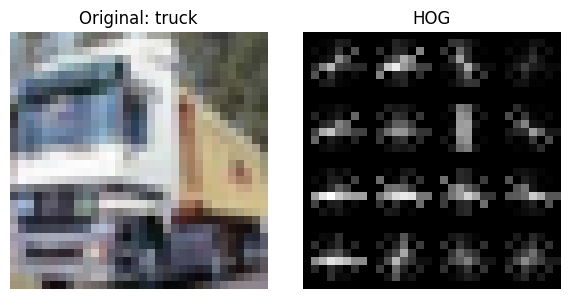

In [26]:
# Pick one image (or loop over a few)
i = 1
img = X_train[i]  # shape (32, 32, 3), uint8
label = label_names[y_train[i]]

# Convert to grayscale
img_gray = color.rgb2gray(img)  # float64, range [0,1]

# Compute HOG with visualization
hog_features, hog_image = hog(
    img_gray,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    visualize=True
)

print("HOG feature length:", hog_features.shape)

# Rescale HOG image for display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, hog_image.max()))

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original: {label}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap="gray")
plt.title("HOG")
plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
def compute_hog_batch(X):
    hog_list = []
    for img in X:
        # grayscale
        gray = color.rgb2gray(img)
        feats = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            visualize=False
        )
        hog_list.append(feats)
    return np.array(hog_list, dtype=np.float32)

In [7]:
X_train_sub_img, y_train_sub, X_test_sub_img, y_test_sub = select_stratified_subset(X_train, y_train,
    X_test, y_test,
    1000, 200)

Train shape: (10000, 32, 32, 3) Test shape: (2000, 32, 32, 3)


In [15]:
print("Computing HOG for train subset...")
X_train_hog = compute_hog_batch(X_train_sub_img)
print("Train HOG shape:", X_train_hog.shape)

print("Computing HOG for test subset...")
X_test_hog = compute_hog_batch(X_test_sub_img)
print("Test HOG shape:", X_test_hog.shape)


Computing HOG for train subset...
Train HOG shape: (10000, 324)
Computing HOG for test subset...
Test HOG shape: (2000, 324)


In [32]:
# 1) Linear SVM on HOG
linear_hog = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(C=1.0, max_iter=10000))
])

print("\nTraining LinearSVC on HOG...")
start = time.perf_counter()
linear_hog.fit(X_train_hog, y_train_sub)
t = time.perf_counter() - start

y_pred = linear_hog.predict(X_test_hog)
acc = accuracy_score(y_test_sub, y_pred)
macro_f1 = f1_score(y_test_sub, y_pred, average="macro")

results.append({
    "name": "LinearSVC_HOG_C1",
    "train_time": t,
    "test_accuracy": acc,
    "test_macro_f1": macro_f1,
})

print(f"Done in {t:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")

model_path = os.path.join("saved_models", f"LinearSVC_HOG_C1.joblib")
joblib.dump(model, model_path)
summary = [
    {
        "name": r["name"],
        "train_time": r["train_time"],
        "test_accuracy": r["test_accuracy"],
        "test_macro_f1": r["test_macro_f1"],
    }
    for r in results
]

with open("saved_models/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)
    




Training LinearSVC on HOG...
Done in 15.54 sec - Test Acc: 0.4780, Macro F1: 0.4713


In [ ]:
# 2) RBF SVM on HOG
rbf_hog = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=10.0, gamma="scale"))
])

print("\nTraining RBF SVC on HOG...")
start = time.perf_counter()
rbf_hog.fit(X_train_hog, y_train_sub)
t = time.perf_counter() - start

y_pred = rbf_hog.predict(X_test_hog)
acc = accuracy_score(y_test_sub, y_pred)
macro_f1 = f1_score(y_test_sub, y_pred, average="macro")

results.append({
    "name": "RBF_HOG_C10_gamma_scale",
    "train_time": t,
    "test_accuracy": acc,
    "test_macro_f1": macro_f1,
})

print(f"Done in {t:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")



model_path = os.path.join("saved_models", f"RBF_HOG_C10_gamma_scale.joblib")
joblib.dump(model, model_path)
summary = [
    {
        "name": r["name"],
        "train_time": r["train_time"],
        "test_accuracy": r["test_accuracy"],
        "test_macro_f1": r["test_macro_f1"],
    }
    for r in results
]

with open("saved_models/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)


Training RBF SVC on HOG...
Done in 25.19 sec - Test Acc: 0.5590, Macro F1: 0.5585


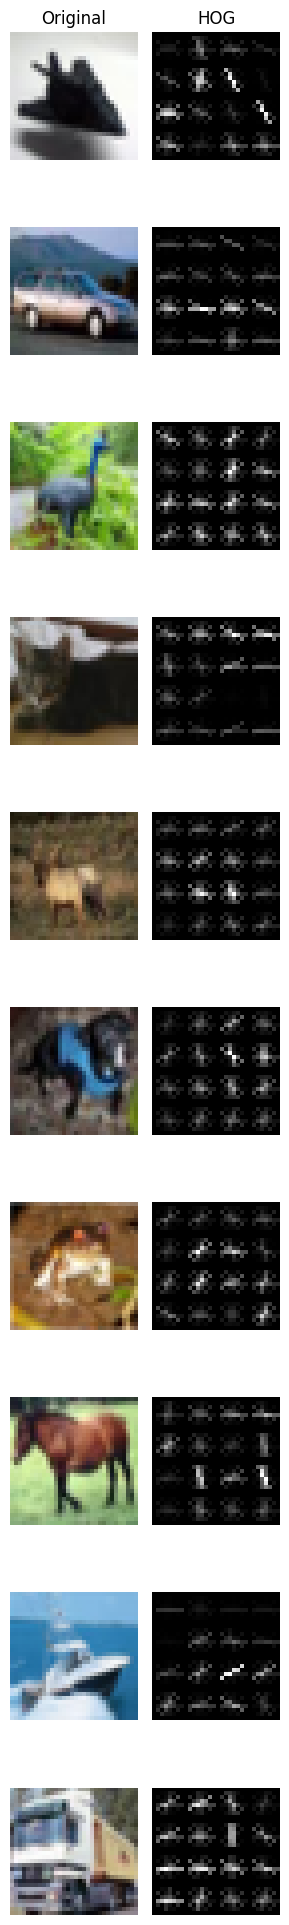

In [36]:
import numpy as np
from skimage.feature import hog
from skimage import color, exposure

num_classes = len(label_names)
examples_per_class = 1  # one example each

plt.figure(figsize=(3 * examples_per_class, 2 * num_classes))

row = 0
for c in range(num_classes):
    # find one image of this class
    idx = np.where(y_train == c)[0][0]
    img = X_train[idx]
    label = label_names[c]

    img_gray = color.rgb2gray(img)
    _, hog_image = hog(
        img_gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=True
    )
    hog_img = exposure.rescale_intensity(hog_image, in_range=(0, hog_image.max()))

    # original
    plt.subplot(num_classes, 2, 2 * row + 1)
    plt.imshow(img)
    if row == 0:
        plt.title("Original")
    plt.ylabel(label)
    plt.axis("off")

    # hog
    plt.subplot(num_classes, 2, 2 * row + 2)
    plt.imshow(hog_img, cmap="gray")
    if row == 0:
        plt.title("HOG")
    plt.axis("off")

    row += 1

plt.tight_layout()
plt.show()


To better understand the HOG representation, we visualised the HOG descriptor for a sample CIFAR-10 image (Figure X).
The right-hand image shows the HOG “edge map”: each bright line corresponds to a cell where gradient magnitude is high, and its direction encodes the dominant edge orientation in that local region.
As a result, the HOG visualisation highlights the object contours and main structural edges (e.g. outline of the airplane, wings, tail), while suppressing fine-grained texture and colour information. This explains why SVMs trained on HOG features achieve higher accuracy and F1 compared to SVMs trained directly on raw RGB pixels: the classifier operates on a compact, contrast-normalised description of local edge orientations that is more informative for object shape.

For SVMs on raw flattened pixels, the best configuration (polynomial kernel, degree 3) reached 44.0% test accuracy (macro F1 0.44) with training time ≈ 215 s.
After extracting HOG features, a linear SVM already improved to 47.8% accuracy, and an RBF SVM with 
C=10 and γ=scale further increased performance to 55.9% accuracy (macro F1 0.56) while training in only 25 s.
This confirms that a suitable feature representation (HOG) is crucial for classical SVMs on CIFAR-10 and can significantly improve both accuracy and training speed.

Now let's attempt to train on the whole dataset.

In [11]:
print("Computing HOG for train subset...")
X_train_hog_full = compute_hog_batch(X_train)
print("Train HOG shape:", X_train_hog_full.shape)

print("Computing HOG for test subset...")
X_test_hog_full = compute_hog_batch(X_test)
print("Test HOG shape:", X_test_hog_full.shape)


Computing HOG for train subset...
Train HOG shape: (50000, 324)
Computing HOG for test subset...
Test HOG shape: (10000, 324)


In [ ]:
# 3) RBF SVM on HOG Whole dataset
rbf_hog = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=10.0, gamma="scale"))
])

print("\nTraining RBF SVC on HOG on FULL dataset......")
start = time.perf_counter()
rbf_hog.fit(X_train_hog_full, y_train)
t = time.perf_counter() - start

y_pred = rbf_hog.predict(X_test_hog_full)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

results.append({
    "name": "RBF_HOG_C10_gamma_scale_whole",
    "train_time": t,
    "test_accuracy": acc,
    "test_macro_f1": macro_f1,
})

print(f"Done in {t:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")



model_path = os.path.join("saved_models", f"RBF_HOG_C10_gamma_scale_whole.joblib")
joblib.dump(rbf_hog, model_path)
summary = [
    {
        "name": r["name"],
        "train_time": r["train_time"],
        "test_accuracy": r["test_accuracy"],
        "test_macro_f1": r["test_macro_f1"],
    }
    for r in results
]

with open("saved_models/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)


Training RBF SVC on HOG on FULL dataset......
Done in 1087.53 sec - Test Acc: 0.6362, Macro F1: 0.6360


Let's Visualise SVM's workings

Using feature indices: 28 250
Classes present in this 2D slice: [4 9]


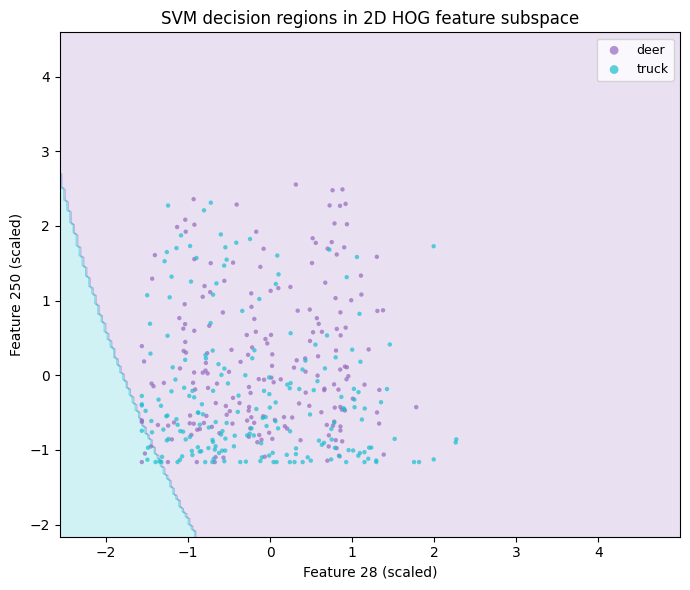

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1) Παρουμε scaled test features
n_plot = 2000
X_plot = X_test_hog_full[:n_plot]
y_plot = y_test[:n_plot]

scaler = rbf_hog.named_steps["scaler"]
clf    = rbf_hog.named_steps["clf"]

X_plot_scaled = scaler.transform(X_plot)
d = X_plot_scaled.shape[1]

# 2) Διαλεγουμε 2 τυχαια features
rng = np.random.default_rng(42)
i1, i2 = rng.choice(d, size=2, replace=False)
print("Using feature indices:", i1, i2)

X1 = X_plot_scaled[:, i1]
X2 = X_plot_scaled[:, i2]

x1_min, x1_max = X1.min() - 1, X1.max() + 1
x2_min, x2_max = X2.min() - 1, X2.max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 200),
    np.linspace(x2_min, x2_max, 200)
)

# 3) Grid στον scaled χωρο
X_mean_scaled = X_plot_scaled.mean(axis=0)
grid_points   = np.c_[xx1.ravel(), xx2.ravel()]

X_grid_scaled = np.tile(X_mean_scaled, (grid_points.shape[0], 1))
X_grid_scaled[:, i1] = grid_points[:, 0]
X_grid_scaled[:, i2] = grid_points[:, 1]

Z = clf.predict(X_grid_scaled).reshape(xx1.shape)

# 4) Βρισκουμε ποιες κλασεις εμφανιζονται στην προβλεψη του grid
pred_classes = np.unique(Z)
print("Classes present in this 2D slice:", pred_classes)

# 5) Φτιαχνουμε colormap για αυτες τις κλασεις
colors_all = plt.cm.tab10(np.linspace(0, 1, len(label_names)))
colors_map = {c: colors_all[c] for c in pred_classes}

class_to_idx = {c: i for i, c in enumerate(pred_classes)}
Z_mapped = np.vectorize(class_to_idx.get)(Z)

cmap_light = ListedColormap([colors_map[c] for c in pred_classes])

plt.figure(figsize=(7, 6))

# background regions
plt.contourf(xx1, xx2, Z_mapped, alpha=0.2, cmap=cmap_light)

# 6) Scatter μονο για αυτες τις κλασεις
for c in pred_classes:
    mask = (y_plot == c)
    plt.scatter(
        X1[mask],
        X2[mask],
        s=10,
        color=colors_map[c],
        label=label_names[c],
        edgecolors="none",
        alpha=0.7,
    )

plt.xlabel(f"Feature {i1} (scaled)")
plt.ylabel(f"Feature {i2} (scaled)")
plt.title("SVM decision regions in 2D HOG feature subspace")
plt.legend(markerscale=2, fontsize=9)
plt.tight_layout()
plt.show()


In [18]:
# 3) RBF SVM on HOG Whole dataset
rbf_hog = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=150.0, gamma="scale"))
])

print("\nTraining RBF SVC on HOG on FULL dataset......")
start = time.perf_counter()
rbf_hog.fit(X_train_hog_full, y_train)
t = time.perf_counter() - start

y_pred = rbf_hog.predict(X_test_hog_full)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

results.append({
    "name": "RBF_HOG_C150_gamma_scale_whole",
    "train_time": t,
    "test_accuracy": acc,
    "test_macro_f1": macro_f1,
})

print(f"Done in {t:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")



model_path = os.path.join("saved_models", f"RBF_HOG_C150_gamma_scale_whole.joblib")
joblib.dump(rbf_hog, model_path)
summary = [
    {
        "name": r["name"],
        "train_time": r["train_time"],
        "test_accuracy": r["test_accuracy"],
        "test_macro_f1": r["test_macro_f1"],
    }
    for r in results
]

with open("saved_models/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)


Training RBF SVC on HOG on FULL dataset......
Done in 1203.82 sec - Test Acc: 0.6366, Macro F1: 0.6364


Using feature indices: 28 250
Classes present in this 2D slice: [4 9]


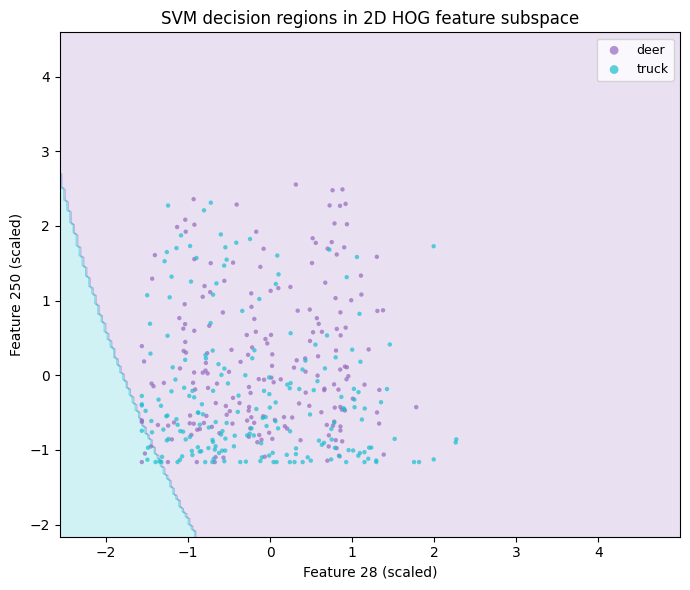

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1) Παρουμε scaled test features
n_plot = 2000
X_plot = X_test_hog_full[:n_plot]
y_plot = y_test[:n_plot]

scaler = rbf_hog.named_steps["scaler"]
clf    = rbf_hog.named_steps["clf"]

X_plot_scaled = scaler.transform(X_plot)
d = X_plot_scaled.shape[1]

# 2) Διαλεγουμε 2 τυχαια features
rng = np.random.default_rng(42)
i1, i2 = rng.choice(d, size=2, replace=False)
print("Using feature indices:", i1, i2)

X1 = X_plot_scaled[:, i1]
X2 = X_plot_scaled[:, i2]

x1_min, x1_max = X1.min() - 1, X1.max() + 1
x2_min, x2_max = X2.min() - 1, X2.max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 200),
    np.linspace(x2_min, x2_max, 200)
)

# 3) Grid στον scaled χωρο
X_mean_scaled = X_plot_scaled.mean(axis=0)
grid_points   = np.c_[xx1.ravel(), xx2.ravel()]

X_grid_scaled = np.tile(X_mean_scaled, (grid_points.shape[0], 1))
X_grid_scaled[:, i1] = grid_points[:, 0]
X_grid_scaled[:, i2] = grid_points[:, 1]

Z = clf.predict(X_grid_scaled).reshape(xx1.shape)

# 4) Βρισκουμε ποιες κλασεις εμφανιζονται στην προβλεψη του grid
pred_classes = np.unique(Z)
print("Classes present in this 2D slice:", pred_classes)

# 5) Φτιαχνουμε colormap για αυτες τις κλασεις
colors_all = plt.cm.tab10(np.linspace(0, 1, len(label_names)))
colors_map = {c: colors_all[c] for c in pred_classes}

class_to_idx = {c: i for i, c in enumerate(pred_classes)}
Z_mapped = np.vectorize(class_to_idx.get)(Z)

cmap_light = ListedColormap([colors_map[c] for c in pred_classes])

plt.figure(figsize=(7, 6))

# background regions
plt.contourf(xx1, xx2, Z_mapped, alpha=0.2, cmap=cmap_light)

# 6) Scatter μονο για αυτες τις κλασεις
for c in pred_classes:
    mask = (y_plot == c)
    plt.scatter(
        X1[mask],
        X2[mask],
        s=10,
        color=colors_map[c],
        label=label_names[c],
        edgecolors="none",
        alpha=0.7,
    )

plt.xlabel(f"Feature {i1} (scaled)")
plt.ylabel(f"Feature {i2} (scaled)")
plt.title("SVM decision regions in 2D HOG feature subspace")
plt.legend(markerscale=2, fontsize=9)
plt.tight_layout()
plt.show()


Για να οπτικοποιησουμε τον τροπο λειτουργιας του SVM, προβαλαμε τα HOG χαρακτηριστικα σε εναν δισδιαστατο υποχωρο, επιλεγοντας δυο τυχαιες διαστασεις. Στο διαγραμμα, το υποβαθρο δειχνει τις περιοχες του χωρου στις οποιες το μοντελο προβλεπει καθε κλαση (decision regions), ενω τα σημεια αντιστοιχουν σε δειγματα του test set. Αν και οι κλασεις παραμενουν σημαντικα επικαλυπτομενες σε αυτη τη δισδιαστατη προβολη, φαινεται οτι το μοντελο μαθαινει μη γραμμικα συνορα που χωριζουν περιοχες με διαφορετικη κατανομη δειγματων ανα κλαση, δειχνοντας την ιδεα του margin-based classification σε εναν υποχωρο των HOG features.